# Prior to February 24, our team had come up with an idea we wanted to follow.
# You can view our R code within the repository which has the necessary filters to get the filtered data that we're utilizing for analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
params = {'figure.figsize': (20, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large'
         }
pylab.rcParams.update(params)

# The analysis we are investigating is in regards to direct passes that led to a shot.

# Alas, with the filtered data, we were left with 1016 unique events from a direct pass that led to a shot on net.

In [3]:
df = pd.read_csv('data_2020-02-24.csv')

In [4]:
df.head(3)

,game_date,home_team,away_team,period,game_seconds,time_since_pass,home_team_goals,away_team_goals,team,game_state,...,shot_y,shot_type,shot_outcome,shot_traffic,shot_onetimer,pass_dist,pass_angle,shooter_dist,shot_dist,shot_angle
0,2021-01-23,Minnesota Whitecaps,Boston Pride,1,53,1,0,0,Minnesota Whitecaps,5v5,...,67,Snapshot,Missed,False,False,8.062258,-56.725112,7.211103,32.557641,-47.489553
1,2021-01-23,Minnesota Whitecaps,Boston Pride,1,86,2,0,0,Boston Pride,5v5,...,17,Snapshot,On Net,False,False,39.661064,10.491477,9.219544,29.529646,61.699244
2,2021-01-23,Minnesota Whitecaps,Boston Pride,1,190,0,0,0,Minnesota Whitecaps,5v5,...,42,Snapshot,On Net,False,False,19.646883,132.273689,5.099020,8.062258,7.125016


In [5]:
df.columns

Index(['game_date', 'home_team', 'away_team', 'period', 'game_seconds',
       'time_since_pass', 'home_team_goals', 'away_team_goals', 'team',
       'game_state', 'passer', 'shooter', 'pass_x', 'pass_y', 'rec_x', 'rec_y',
       'shot_x', 'shot_y', 'shot_type', 'shot_outcome', 'shot_traffic',
       'shot_onetimer', 'pass_dist', 'pass_angle', 'shooter_dist', 'shot_dist',
       'shot_angle'],
      dtype='object')

## Plotting initial visualizations to infer potential useful trends and relationships.  

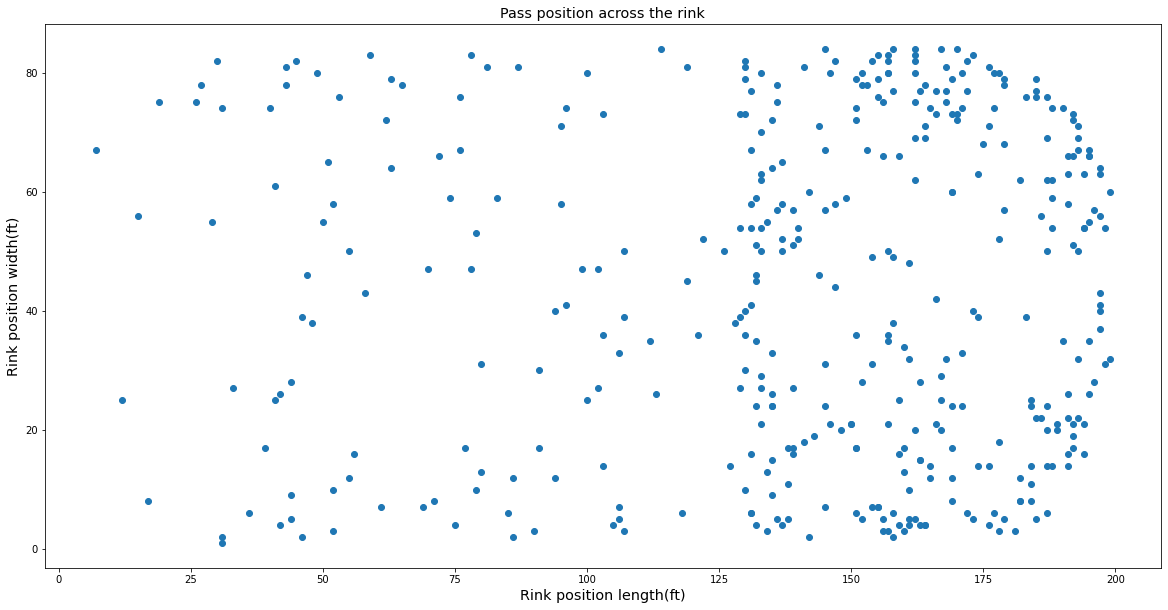

In [6]:
plt.scatter(df.pass_x[0:400], df.pass_y[0:400])
plt.title('Pass position across the rink')
plt.xlabel('Rink position length(ft)')
plt.ylabel('Rink position width(ft)')
plt.show()

Text(0.5, 1.0, 'Frequenecy of occurence vs. time since pass')

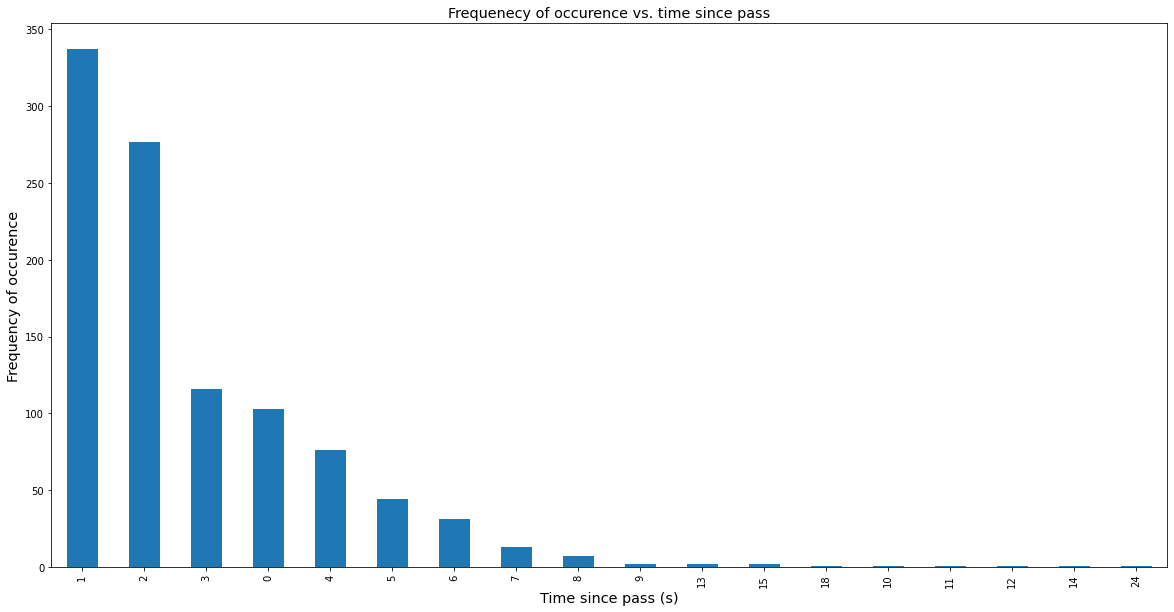

In [7]:
fig, ax = plt.subplots()
df['time_since_pass'].value_counts().plot(ax=ax, kind='bar')
plt.xlabel('Time since pass (s)')
plt.ylabel('Frequency of occurence')
plt.title('Frequenecy of occurence vs. time since pass')

Text(0.5, 1.0, 'Pass distance vs. shot distance that resulted in goals')

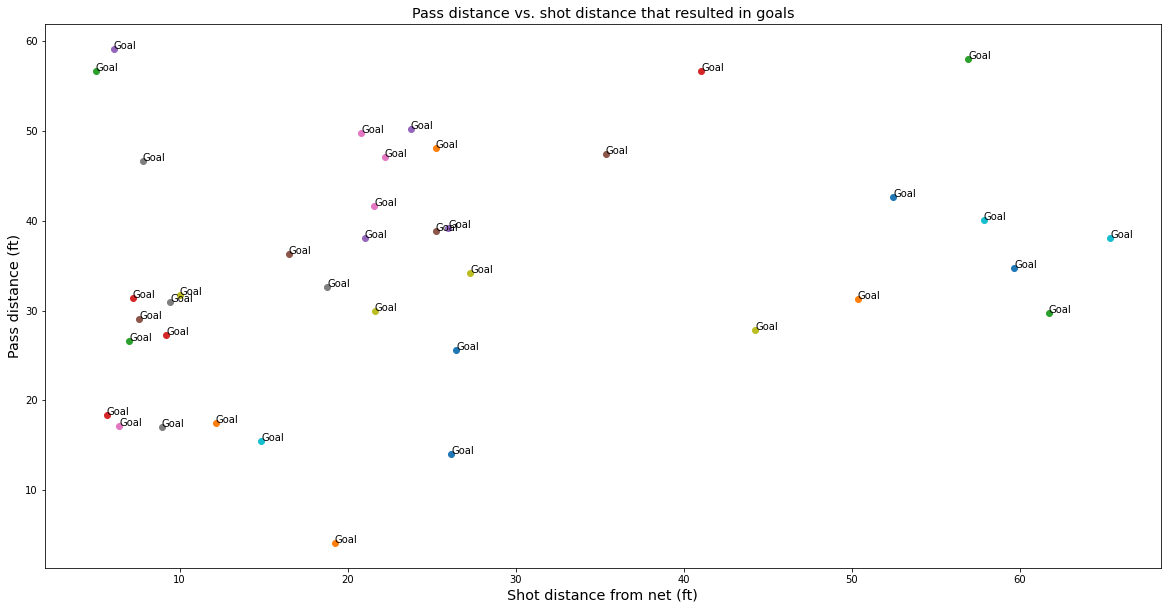

In [8]:
for i, txt in enumerate(df['shot_outcome']):
    if df['shot_outcome'][i] == 'Goal':
        plt.scatter(df.shot_dist[i], df.pass_dist[i])
        plt.annotate(txt, (df.shot_dist[i], df.pass_dist[i]))
plt.xlabel('Shot distance from net (ft)')
plt.ylabel('Pass distance (ft)')
plt.title('Pass distance vs. shot distance that resulted in goals')

Text(0.5, 1.0, 'Pass distance vs. shot distance for all shots')

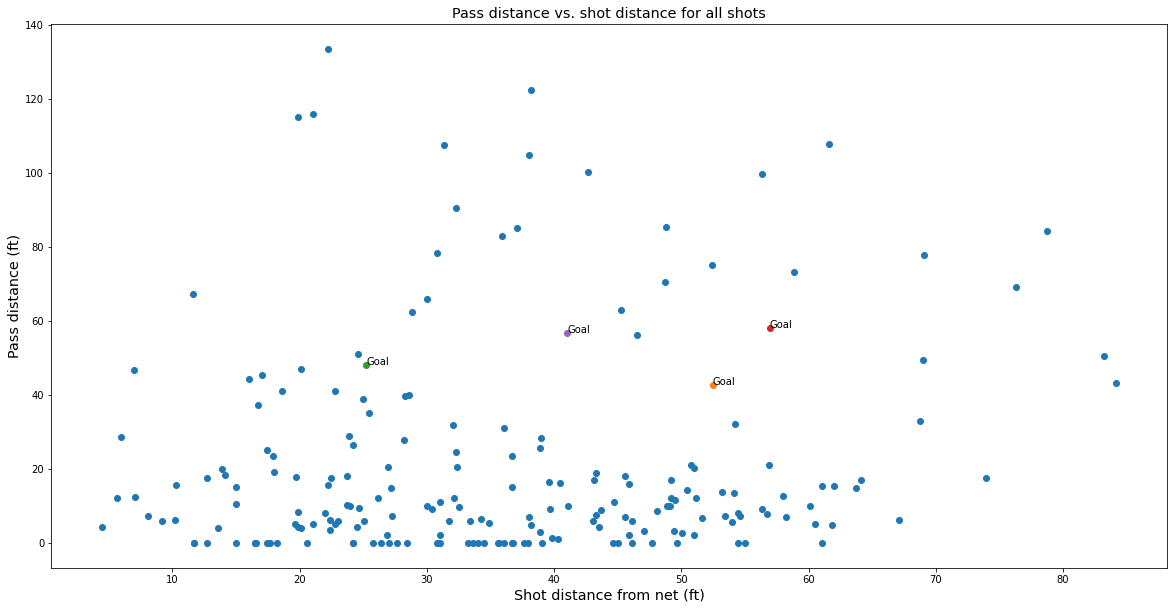

In [9]:
plt.scatter(df.pass_dist[0:200], df.shooter_dist[0:200])
for i, txt in enumerate(df['shot_outcome']):
    if df['shot_outcome'][i] == 'Goal':
        plt.scatter(df.shot_dist[i], df.pass_dist[i])
        plt.annotate(txt, (df.shot_dist[i], df.pass_dist[i]))
    if i >200:
        break
plt.xlabel('Shot distance from net (ft)')
plt.ylabel('Pass distance (ft)')
plt.title('Pass distance vs. shot distance for all shots')

## From the above plot, looking at 200 shot outcomes plotted, it appears there's a fairly strong linear relationship that's identified between the shot distance from the new and the pass distance

Text(0.5, 1.0, 'Time since pass vs. pass distance')

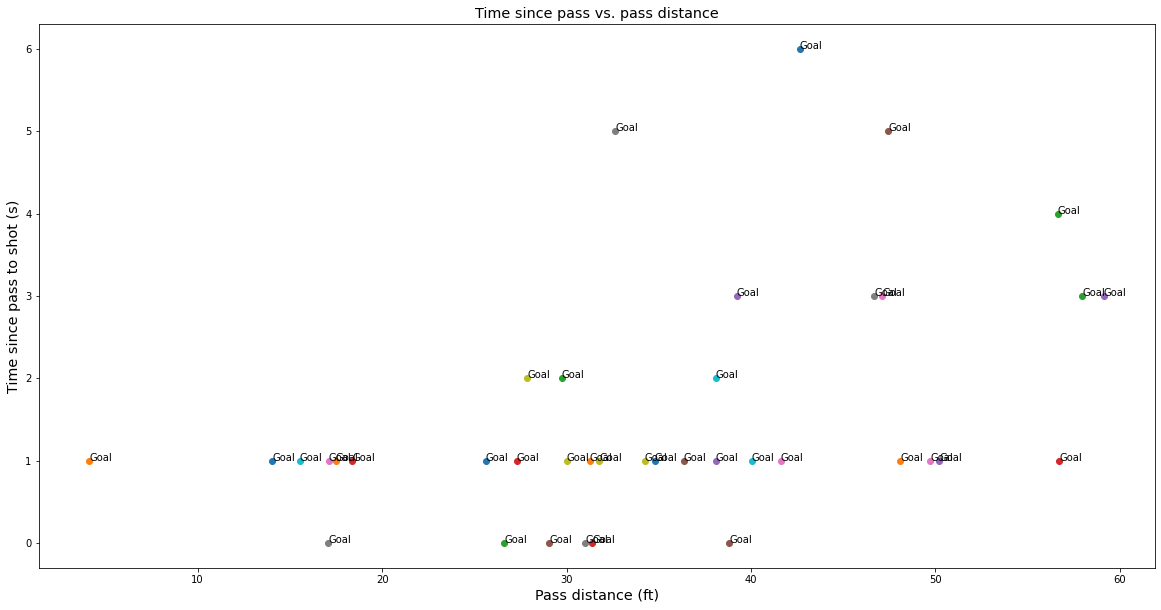

In [10]:
for i, txt in enumerate(df['shot_outcome']):
    if df['shot_outcome'][i] == 'Goal':
        plt.scatter(df.pass_dist[i], df.time_since_pass[i])
        plt.annotate(txt, (df.pass_dist[i], df.time_since_pass[i]))
plt.xlabel('Pass distance (ft)')
plt.ylabel('Time since pass to shot (s)')
plt.title('Time since pass vs. pass distance')

Text(0.5, 1.0, 'Time since pass vs. shooter distance')

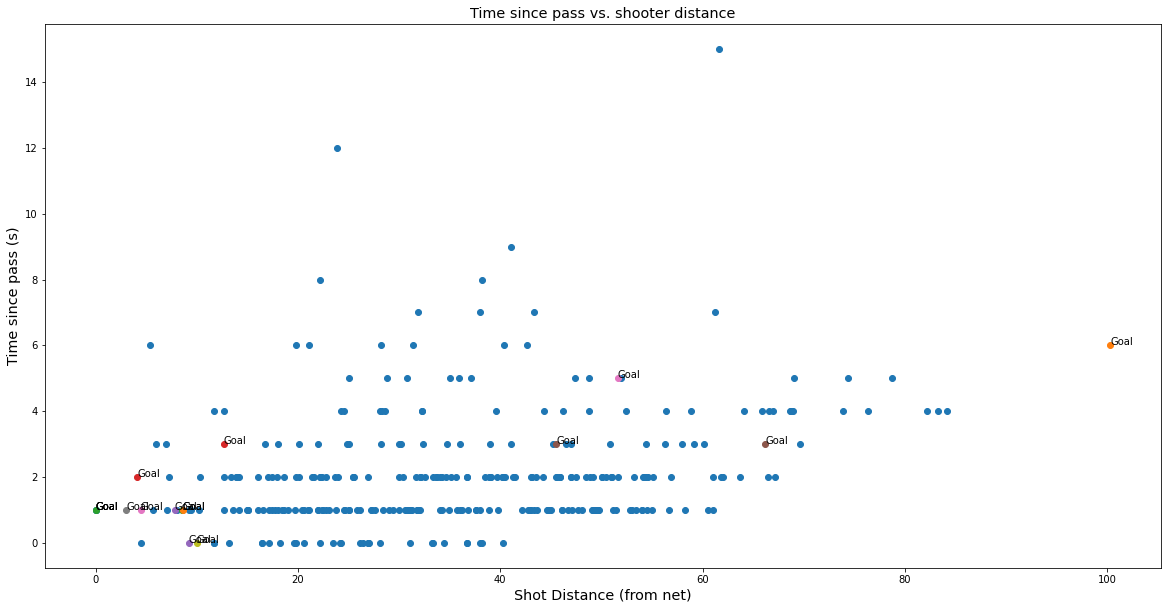

In [11]:
plt.scatter(df.pass_dist[0:300], df.time_since_pass[0:300])
for i, txt in enumerate(df['shot_outcome']):
    if df['shot_outcome'][i] == 'Goal':
        plt.scatter(df.shooter_dist[i], df.time_since_pass[i])
        plt.annotate(txt, (df.shooter_dist[i], df.time_since_pass[i]))
    if i >500:
        break
plt.xlabel('Shot Distance (from net)')
plt.ylabel('Time since pass (s)')
plt.title('Time since pass vs. shooter distance')

## Frequency of each shot occurence

Text(0.5, 1.0, 'Frequency of each type of shot')

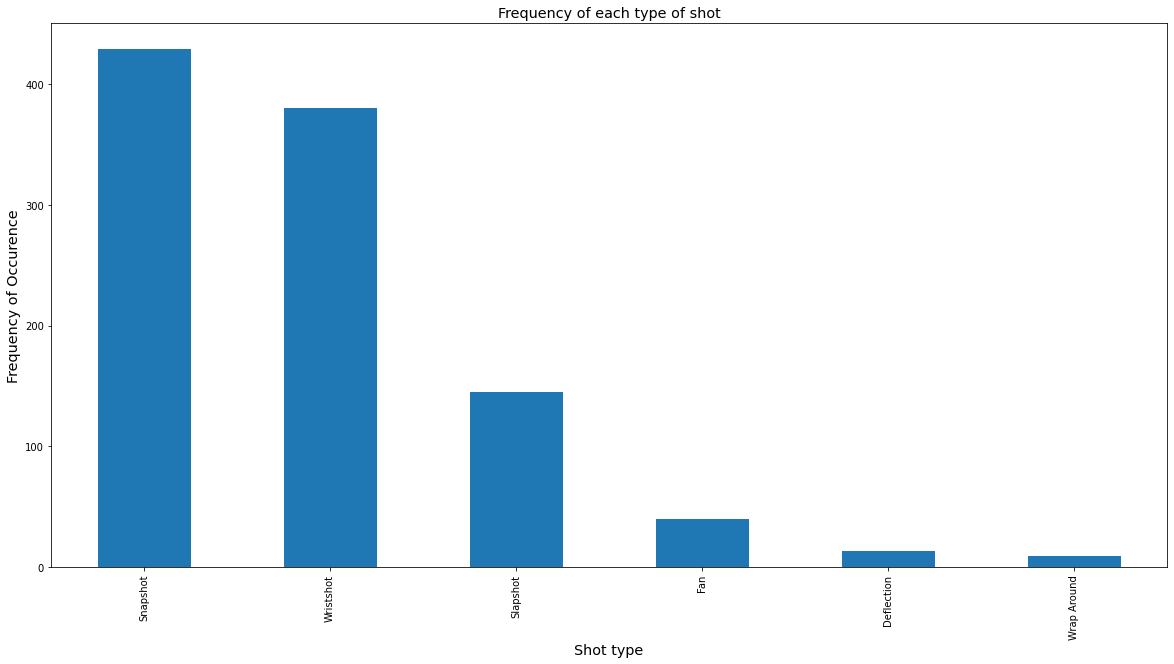

In [12]:
fig, ax = plt.subplots()
df['shot_type'].value_counts().plot(ax=ax, kind='bar')
plt.xlabel('Shot type')
plt.ylabel('Frequency of Occurence')
plt.title('Frequency of each type of shot')

Text(0.5, 1.0, 'Frequency of shots that were one timers or not')

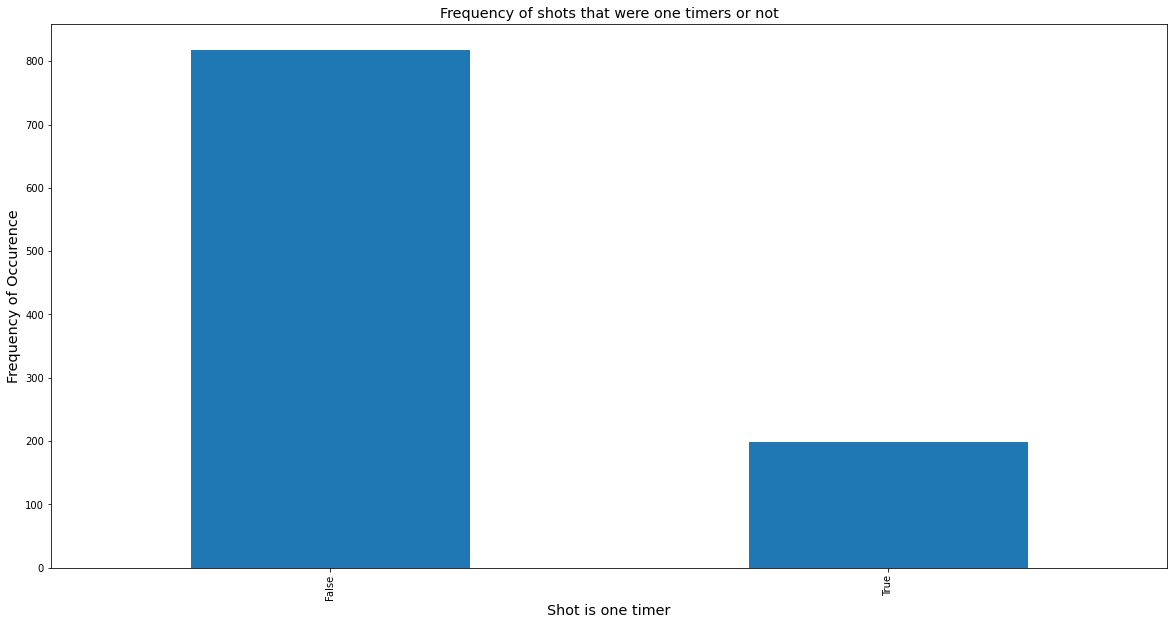

In [13]:
fig, ax = plt.subplots()
df['shot_onetimer'].value_counts().plot(ax=ax, kind='bar')
plt.xlabel('Shot is one timer')
plt.ylabel('Frequency of Occurence')
plt.title('Frequency of shots that were one timers or not')

Text(0.5, 1.0, 'Frequency of shots that had traffic')

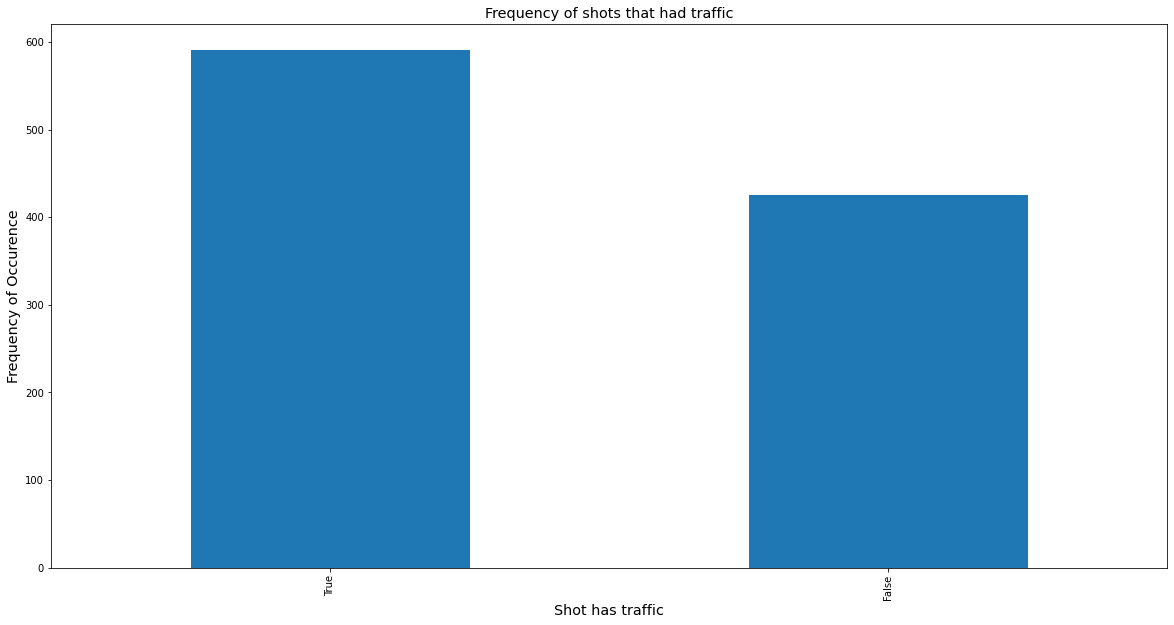

In [14]:
fig, ax = plt.subplots()
df['shot_traffic'].value_counts().plot(ax=ax, kind='bar')
plt.xlabel('Shot has traffic')
plt.ylabel('Frequency of Occurence')
plt.title('Frequency of shots that had traffic')

## Moving on to making predictive models.

# Firstly we'll start with a Random Forest Classifier (RFC) as it doesn't require normalization/ standardization of features and can be used to find feature importances, which will help us reduce the features necessary to create further models.

In [15]:
y = df['shot_outcome'].str.contains('Goal|On Net')
X = df.drop(columns=['shot_outcome'])
dropped_columns = ['game_date']
X = X.drop(columns=dropped_columns)

In [16]:
# utilize pandas get dummies to turn textual features into numerical binary features
dummies_columns = ['team','passer','shooter', 'shot_type', 'game_state', 'home_team', 'away_team']
X_dummies = pd.get_dummies(X, prefix_sep='-', columns = dummies_columns)

In [17]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.33, random_state=13)
rfc = RandomForestClassifier(random_state=12)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=12)

In [18]:
rfc.predict(X_test)[:10]

array([False,  True,  True, False, False, False, False, False, False,
        True])

In [19]:
confusion_matrix(y_test, rfc.predict(X_test))

array([[121,  66],
       [ 58,  91]])

In [20]:
precision_score(y_test, rfc.predict(X_test))

0.5796178343949044

In [21]:
recall_score(y_test, rfc.predict(X_test))

0.610738255033557

### Baseline of precision 57.9% and recall of 61.0%.
### Utilize a feature reduction mechanism of recursive feature estimation to determine our most important features.

In [22]:
# perform recursive feature estimation to determine the most important features
rfe = RFE(estimator=rfc, n_features_to_select=30, step=1)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(random_state=12), n_features_to_select=30)

In [23]:
rfe.predict(X_test)[:10]

array([ True,  True,  True, False, False, False, False, False, False,
        True])

In [24]:
confusion_matrix(y_test, rfe.predict(X_test))

array([[119,  68],
       [ 61,  88]])

In [25]:
precision_score(y_test, rfe.predict(X_test))

0.5641025641025641

In [26]:
recall_score(y_test, rfe.predict(X_test))

0.5906040268456376

## By reducing the amount of model factors from over 300 to 30, model precision has decreased to 56.4% with recall decreasing to 59.0%. We'll test other models to see if this relationship of using more data results in better performing models. 

### Looking at top 15 values of feature importance for RFC model

In [27]:
features = X_test.columns[0:15]
importances = rfc.feature_importances_[0:15]
indices = np.argsort(importances)

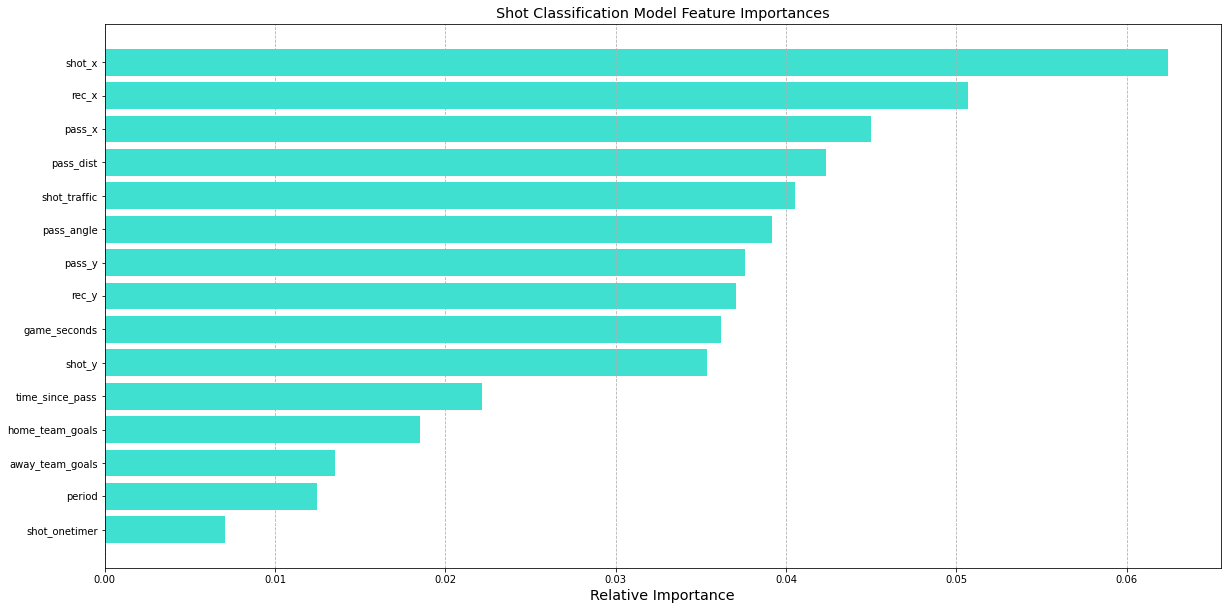

In [28]:
plt.title('Shot Classification Model Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='turquoise', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.gca().xaxis.grid(True, linestyle='--')
plt.show()

# Comparing RFC with Logistic Regressor (LR).

### Firstly need to scale data now that we're not using RFC anymore.

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
lr = LogisticRegression(random_state=13)
lr.fit(X_train_scaled, y_train)

LogisticRegression(random_state=13)

In [31]:
confusion_matrix(y_test, lr.predict(X_test_scaled))

array([[112,  75],
       [ 60,  89]])

In [32]:
precision_score(y_test, lr.predict(X_test_scaled))

0.5426829268292683

In [33]:
recall_score(y_test, lr.predict(X_test_scaled))

0.5973154362416108

# Precision of LR is 54.2% and a recall of 59.7%, lower than that of the RFC.

In [34]:
rfe_lr = RFE(estimator=lr, n_features_to_select=30, step=1)
rfe_lr.fit(X_train_scaled, y_train)

RFE(estimator=LogisticRegression(random_state=13), n_features_to_select=30)

In [35]:
confusion_matrix(y_test, rfe_lr.predict(X_test_scaled))

array([[123,  64],
       [ 58,  91]])

In [36]:
precision_score(y_test, rfe_lr.predict(X_test_scaled))

0.5870967741935483

In [37]:
recall_score(y_test, rfe_lr.predict(X_test_scaled))

0.610738255033557

# Precision of LR after performing RFE is 58.7% and a recall of 61.1%, lower than that of the RFC. This is currently the highest performing model.

## Comparing support vector machine (SVM) with LR and RFC.

In [38]:
svc = LinearSVC(penalty='l2', loss='hinge', random_state=8)
svc.fit(X_train_scaled, y_train)

/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(loss='hinge', random_state=8)

In [39]:
confusion_matrix(y_test, svc.predict(X_test_scaled))

array([[115,  72],
       [ 64,  85]])

In [40]:
precision_score(y_test, svc.predict(X_test_scaled))

0.5414012738853503

In [41]:
recall_score(y_test, svc.predict(X_test_scaled))

0.5704697986577181

# Precision of SVM is 54.1% and a recall of 57.0%, lower than that of the RFC.

In [42]:
rfe_svc = RFE(estimator=svc, n_features_to_select=30, step=1)
rfe_svc.fit(X_train_scaled, y_train)

/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, i

/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, i

/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, i

/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, i

/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, i

/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, i

RFE(estimator=LinearSVC(loss='hinge', random_state=8), n_features_to_select=30)

In [43]:
confusion_matrix(y_test, rfe_svc.predict(X_test_scaled))

array([[122,  65],
       [ 60,  89]])

In [44]:
precision_score(y_test, rfe_svc.predict(X_test_scaled))

0.577922077922078

In [45]:
recall_score(y_test, rfe_svc.predict(X_test_scaled))

0.5973154362416108

# Precision of LR after performing RFE is 57.8% and a recall of 59.7%.

## Comparing models

In [46]:
# Instantiate the classfiers and make a list
classifiers = [RandomForestClassifier(random_state=12),
                LogisticRegression(random_state=13), 
              LinearSVC(penalty='l2', loss='hinge', random_state=8)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yprob = model.predict(X_test)
    
    fpr, tpr, _ = roc_curve(y_test,  yprob)
    auc = roc_auc_score(y_test, yprob)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


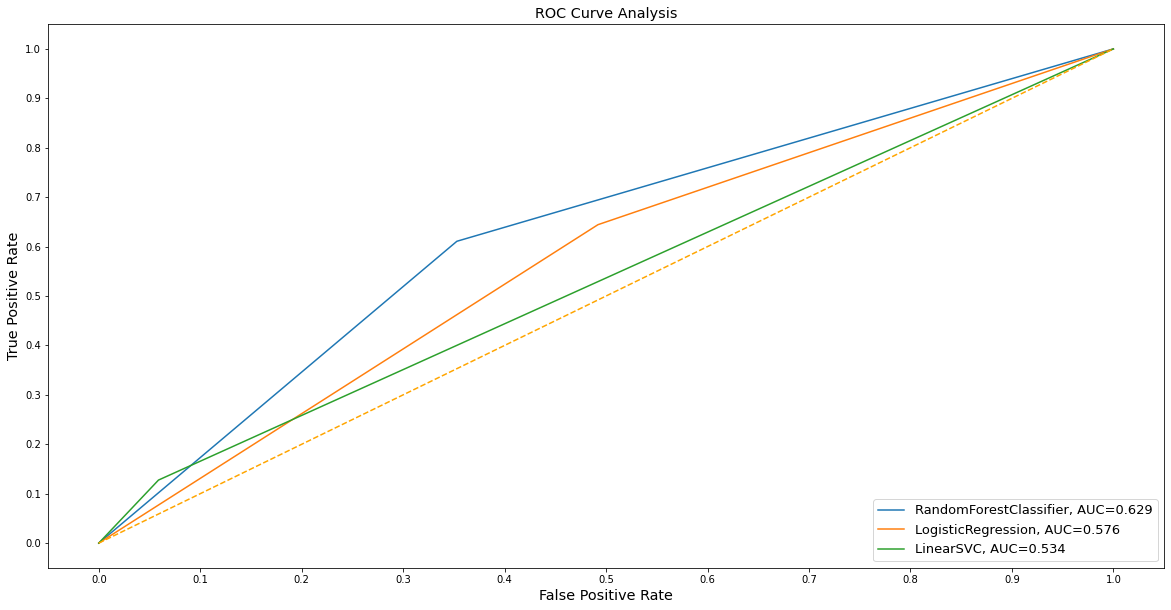

In [47]:
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(result_table.loc[i]['classifiers'], result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate")

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate")

plt.title('ROC Curve Analysis')
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

## From the model comparison plot we see that the area under curve is maximized for the RFC.

## We continue our analysis in the report.